In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature

## create the composite node

In [3]:
struct ExponentialMultiplicationNormal end 

@node ExponentialMultiplicationNormal Stochastic [out, f, x, τ]    # out  = NormalMeanPrecision(exp(f) * x, τ) 


#rule for out 
@rule ExponentialMultiplicationNormal(:out, Marginalisation) (q_f::GaussianDistributionsFamily, q_x::GaussianDistributionsFamily, q_τ::PointMass) = begin 
    m_f, v_f = mean_var(q_f)
    m_x, v_x = mean_var(q_x)

    return NormalMeanPrecision(m_x * exp(m_f + 0.5*v_f), mean(q_τ))
end

### Rule for f 
@rule ExponentialMultiplicationNormal(:f, Marginalisation) (q_out::GaussianDistributionsFamily, q_x::GaussianDistributionsFamily, q_τ::PointMass) = begin
    m_x, v_x = mean_var(q_x)
    m_out = mean(q_out)

    m_f = m_x * m_out / (v_x + m_x^2)
    β = (v_x + m_x^2) * mean(q_τ)

    return ContinuousUnivariateLogPdf((x) -> logpdf(NormalMeanPrecision(m_f, β), exp(x)))
end

@rule ExponentialMultiplicationNormal(:f, Marginalisation) (q_out::PointMass, q_x::GaussianDistributionsFamily, q_τ::PointMass, meta::ProcessMeta) = begin 
    m_x, v_x = mean_var(q_x)
    m_out = mean(q_out)

    m_f = m_x * m_out / (v_x + m_x^2)
    β = (v_x + m_x^2) * mean(q_τ)

    return ContinuousUnivariateLogPdf((x) -> logpdf(NormalMeanPrecision(m_f, β), exp(x)))
end

### Rule for τ
@rule ExponentialMultiplicationNormal(:τ, Marginalisation) (q_out::GaussianDistributionsFamily, q_f::GaussianDistributionsFamily, q_x::GaussianDistributionsFamily) = begin
    #temporary put here. haven't had the rule for τ yet
    return GammaShapeRate(1., 0.1) 
end

## Rule for x  
@rule ExponentialMultiplicationNormal(:x, Marginalisation) (q_out::GaussianDistributionsFamily, q_f::GaussianDistributionsFamily, q_τ::PointMass) = begin
    m_out = mean(q_out)
    m_f, v_f = mean_var(q_f)

    A = (exp(v_f) - 1) * exp(2*m_f + v_f) + (exp(m_f + 0.5* v_f))^2
    B = m_out * exp(m_f + 0.5*v_f)

    return NormalMeanPrecision(B / A, A * mean(q_τ))
end

@rule ExponentialMultiplicationNormal(:x, Marginalisation) (q_out::PointMass, q_f::GaussianProcess, q_τ::PointMass, meta::ProcessMeta) = begin 
    m_out = mean(q_out)
    m_τ = mean(q_τ)

    #write q_f as Normal 
    index = meta.index
    m_gp, cov_gp = mean_cov(q_f.finitemarginal)
    kernelf = q_f.kernelfunction
    meanf   = q_f.meanfunction
    test    = q_f.testinput
    train   = q_f.traininput
    cov_strategy = q_f.covariance_strategy
    x_u = q_f.inducing_input

    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    m_f = mμ[1]
    v_f = var_μ[1] 
    
    A = (exp(v_f) - 1) * exp(2*m_f + v_f) + (exp(m_f + 0.5* v_f))^2
    B = m_out * exp(m_f + 0.5*v_f)

    return NormalMeanPrecision(B / A, A * m_τ) 
end

## Prepare the data 

In [4]:
function generate_data(n,x_0, f_gp, σ_x, σ_y)
    y=[]
    x = []
    obs = []
    x_prev = x_0
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i]) 
        push!(y,temp)
        push!(x,x_t)    
        push!(obs, temp + σ_y*randn())
    end
    return x, y , obs
end

generate_data (generic function with 1 method)

In [39]:
Random.seed!(1)

σ_x = 2π/10 # true frequency
σ_y = 0.5 ## we assume low noise for now
x_init = 2.0

N = 400; #data length
n = 400; #length of the axis of gp 

## GP information
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 0.3 #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [40]:
#Generate data 
x_true_state,y_true_state,y_data = generate_data(N,x_init,f_train,σ_x,σ_y);

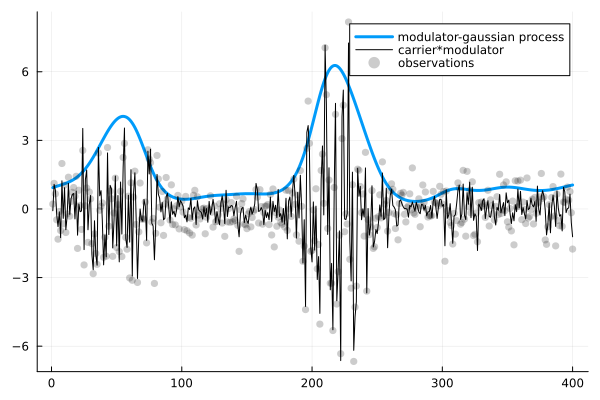

In [41]:
plot(exp.(f_train), label="modulator-gaussian process",linewidth=3.0)
plot!(y_true_state,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Model 

In [49]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, gp_kernel,gp_mean, train,test, gpstrategy, θ_f)
    f = randomprocess(test, train, gpstrategy)
    y = datavar(Float64,n)
    z = randomvar(n)
    
    # θ ~ NormalMeanVariance(log(0.5), 50.)
    β ~ GammaShapeRate(.01, .01)
    f ~ GaussianProcess(gp_mean, gp_kernel, log(0.6)) #where {meta = CVI(StableRNG(42), 1000,200,ADAM(0.01)), pipeline = RequireMarginal(params)}
    # u ~ NormalMeanVariance(0., 50.)
    # z_prior ~ NormalMeanPrecision(0.0, 0.02)
    # z_prev = z_prior 
    for i=1:n 
        z[i] ~ NormalMeanPrecision(0.,β) 
        y[i] ~ ExponentialMultiplicationNormal(f,z[i], 1/σ_y^2) where {meta = ProcessMeta(i)}
        # z_prev = z[i]
    end
end

In [50]:
@constraints function gpconstraints()   
    q(β,f,z) = q(β)q(f)q(z)
end

gpconstraints (generic function with 1 method)

In [71]:
nits =3000
iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), kernel, meanf, time_train,time_range, cov_strategy, θ_gp),
    initmarginals = (β = GammaShapeRate(2.,1.),f = GaussianProcess(meanf,kernel(0.1),MvNormalMeanCovariance(zeros(n),Cov_mat),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits, 
    constraints = gpconstraints(),
    data  = (y = y_data,),
    returnvars = (f = KeepEach(),β = KeepEach(),),
    showprogress = false,
    free_energy = false
)


Inference results:
  Posteriors       | available for (f, β)


In [72]:
mgp = mean(iresult.posteriors[:f][end].data.finitemarginal)
vgp = var(iresult.posteriors[:f][end].data.finitemarginal)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

In [73]:
vgp

400-element Vector{Float64}:
 0.029928296720819203
 0.02718064860212399
 0.024665179079920274
 0.02236876122115694
 0.0202783308061526
 0.018380954101743008
 0.016663891421842436
 0.015114656110031932
 0.013721068635887068
 0.012471305554996315
 ⋮
 0.021678047889606145
 0.02309309311261787
 0.024696432194034612
 0.026502045206009184
 0.028524032884613137
 0.03077654267137664
 0.03327369140954706
 0.036029485220494095
 0.039057737124419845

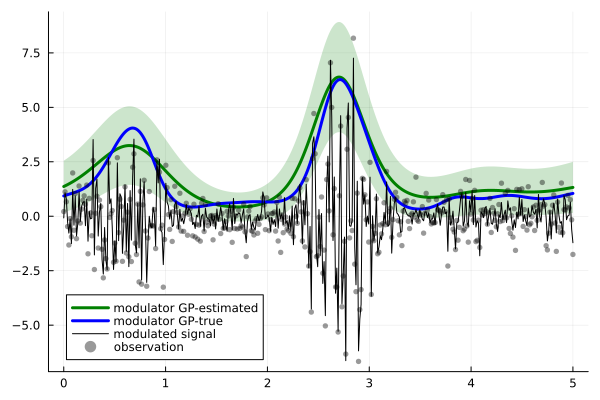

In [74]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)
# plot!(time_range,mean.(iresult.posteriors[:g][end]),ribbon=var.(iresult.posteriors[:g][end]))

In [75]:
iresult.posteriors[:β][end]

GammaShapeRate{Float64}(a=200.01, b=58.77232441820755)

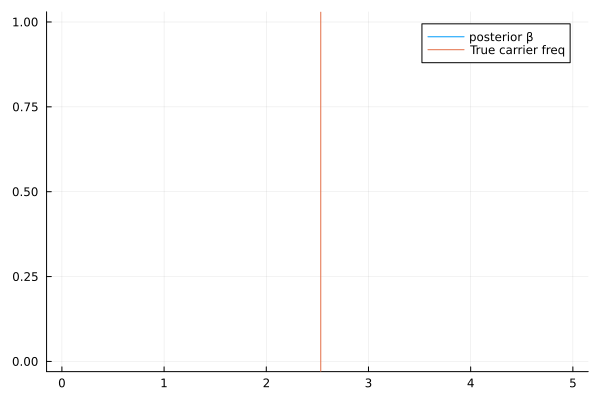

In [76]:
β_infer = mean(iresult.posteriors[:β][end])
inv(sqrt(β_infer))
β_range = collect(0. : 0.01: 5.);
plot(β_range, pdf.(iresult.posteriors[:β][end],β_range), label="posterior β")
vline!([1/(2pi/10)^2], label="True carrier freq")

In [77]:
@show β_infer = mean(iresult.posteriors[:β][end])
inv(sqrt(β_infer))

β_infer = mean((iresult.posteriors[:β])[end]) = 3.4031323753129845


0.5420764980559022

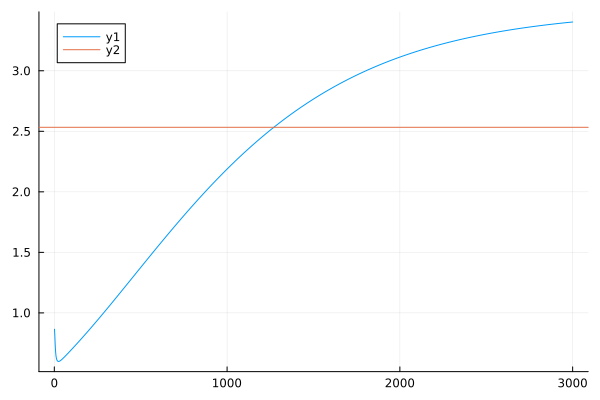

In [78]:
plot(1:nits, mean.(iresult.posteriors[:β]))
hline!([1/(2pi/10)^2])

In [38]:
plot(mean.(iresult.posteriors[:z][end]), size = (800,400))
plot!(x_true_state,label="true")

KeyError: KeyError: key :z not found